##Introduction to the Project

###**About the Project**

This is a 5 layers Sequential Convolutional Neural Network for digits recognition trained on MNIST dataset. The goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. I chose to build it with keras API (Tensorflow backend) which is very intuitive. Firstly, I will prepare the data (handwritten digits images) then i will focus on the CNN modeling and evaluation.

**For computational reasons, i set the number of steps (epochs) to 3**

###**About the Dataset**

MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. A new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

##Setup

Importing all the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import fetch_openml
import itertools
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D #Convolution Layers
from keras.optimizers import RMSprop #Optimiser
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

Additional configurations

In [2]:
np.random.seed(2)
sns.set(style='white', context='notebook', palette='deep')

We will be using TensorFlow as backend.

##Data Preparation

###**Loading the Data**

In [13]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [14]:
Y_train = train["label"]
Y_train

0        1
1        0
2        1
3        4
4        0
        ..
41995    0
41996    1
41997    7
41998    6
41999    9
Name: label, Length: 42000, dtype: int64

In [15]:
X_train = train.drop(labels = ["label"],axis = 1)
X_train

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
#function to print the digit
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [23]:
X=X_train[:50].to_numpy()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

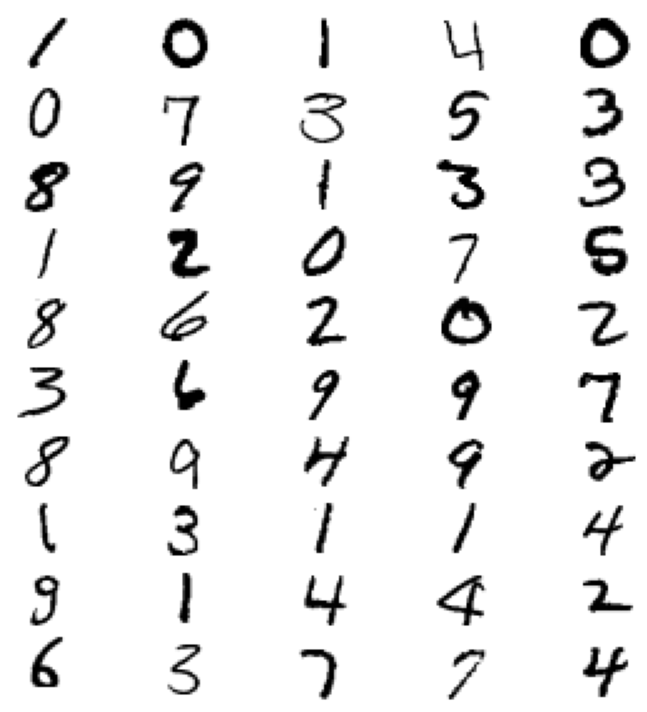

In [25]:
#looking at first 50 digits
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:50]):
    plt.subplot(10, 5, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

Here we will consider 42000 images for training and the remaining 28000 for testing

Plotting to see the distribution of data

In [33]:
yt=pd.DataFrame({'label': Y_train[:]})
yt

,label
0,1
1,0
2,1
3,4
4,0
...,...
41995,0
41996,1
41997,7
41998,6


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

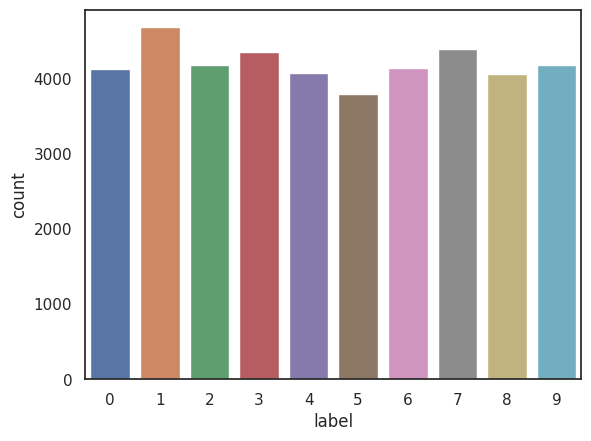

In [34]:
g = sns.countplot(yt,x="label")
Y_train.value_counts()

We get similar count for all the 10 digits.

###**Check for NULL and missing value**

In [35]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [37]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

There is no null or missing values in the train and test dataset. So we can safely go ahead.

###**Normalization**

We perform a grayscale normalization to reduce the effect of illumination's differences.  
  
Moreover the CNN converg faster on [0..1] data than on [0..255].

In [38]:
X_train = X_train / 255.0
test = test / 255.0

###**Reshape**

Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)

In [39]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.

###**Label Encoding**

Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])

In [40]:
Y_train = to_categorical(Y_train, num_classes = 10)

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

###**Split training and valdiation set**

Split the train and the validation set for the fitting

In [42]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)

I chose to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

Since we have 42000 training images of balanced labels, a random split of the train set doesn't cause some labels to be over represented in the validation set. Be carefull with some unbalanced dataset a simple random split could cause inaccurate evaluation during the validation.


We can get a better sense for one of these examples by visualising the image and looking at the label.

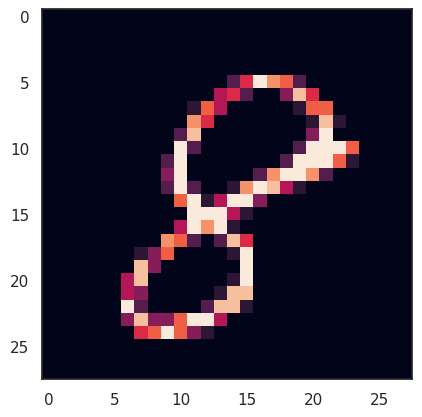

In [43]:
g = plt.imshow(X_train[0][:,:,0])

##CNN

###**Defining the Model**

I used the Keras Sequential API, where you have just to add one layer at a time, starting from the input.

In [44]:
model = Sequential()

My CNN architechture is :  
<pre>Input  -->  [ [Conv2D->relu] *2  -->  MaxPool2D  -->  Dropout ] *2  -->  Flatten  -->  Dense  -->  Dropout  -->  Output</pre>

The first is the convolutional (Conv2D) layer. I chose to set 32 filters for the two firsts conv2D layers. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

In [45]:
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting.

In [46]:
model.add(MaxPool2D(pool_size=(2,2)))

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a proportion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

In [47]:
model.add(Dropout(0.25))

Since the architecture contains the above layers two times in sequence, we will add the same layers once more to our model.  
But this time the conv2D layers contain 64 filters each.

In [48]:
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

The Flatten layer is used to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In [49]:
model.add(Flatten())

In the end i used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

In [50]:
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

###**Set the Optimizer and Annealer**

Once our layers are added to the model, we need to set up a score function, a loss function and an optimisation algorithm.

The most important function is the optimizer. This function will iteratively improve parameters in order to minimise the loss.

I chose RMSprop as it is a very effective optimizer. The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate. We could also have used Stochastic Gradient Descent optimizer, but it is slower than RMSprop.

In [51]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


We define the loss function to measure how poorly our model performs on images with known labels. We use a specific form for categorical classifications called the "categorical_crossentropy".

The metric function "accuracy" is used is to evaluate the performance our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

In [52]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.

To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks, i choose to reduce the LR by half if the accuracy is not improved after 2 epochs.

In [53]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

Setting the hyperparameters

In [54]:
epochs = 3
batch_size = 86

**Fitting the model**

In [55]:
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs,
          validation_data = (X_val, Y_val), verbose = 2)

Epoch 1/3
440/440 - 346s - loss: 0.2416 - accuracy: 0.9223 - val_loss: 0.0625 - val_accuracy: 0.9800 - 346s/epoch - 786ms/step
Epoch 2/3
440/440 - 344s - loss: 0.0727 - accuracy: 0.9782 - val_loss: 0.0558 - val_accuracy: 0.9829 - 344s/epoch - 783ms/step
Epoch 3/3
440/440 - 342s - loss: 0.0566 - accuracy: 0.9834 - val_loss: 0.0389 - val_accuracy: 0.9864 - 342s/epoch - 776ms/step


We have achieved an accuracy of 98.64%

###**Data Augmentation**

In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset by altering the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

By applying just a couple of transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [56]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [57]:
datagen.fit(X_train)

For the data augmentation, i choosed to :

Randomly rotate some training images by 10 degrees  
Randomly Zoom by 10% some training images  
Randomly shift images horizontally by 10% of the width  
Randomly shift images vertically by 10% of the height  
I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

Once our model is ready, we fit the training dataset .

**Fitting the model**

In [58]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/3


<ipython-input-58-00f8d670f626>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),


439/439 - 359s - loss: 0.1351 - accuracy: 0.9595 - val_loss: 0.0383 - val_accuracy: 0.9876 - lr: 0.0010 - 359s/epoch - 818ms/step
Epoch 2/3


439/439 - 355s - loss: 0.0925 - accuracy: 0.9725 - val_loss: 0.0363 - val_accuracy: 0.9867 - lr: 0.0010 - 355s/epoch - 808ms/step
Epoch 3/3


439/439 - 359s - loss: 0.0744 - accuracy: 0.9773 - val_loss: 0.0348 - val_accuracy: 0.9902 - lr: 0.0010 - 359s/epoch - 817ms/step


We have achieved an accuracy of 99.02%

The improvement is important :

Without data augmentation i obtained an accuracy of 98.64%
With data augmentation I achieved 99.02% of accuracy

##Evaluate the Model

###**Training and Validation Curves**

Plot the loss and accuracy curves for training and validation

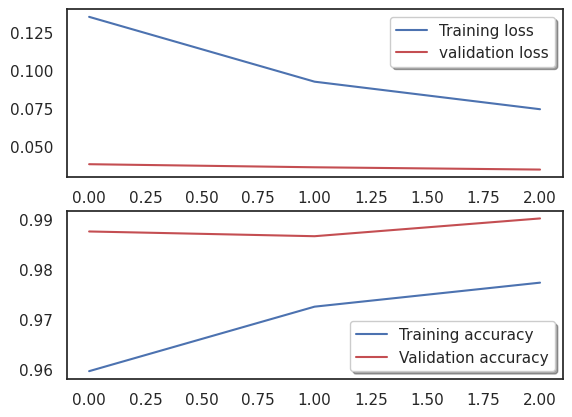

In [60]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

###**Confusion Matrix**

Confusion matrix can be very helpfull to see your model drawbacks.

I plot the confusion matrix of the validation results.

In [61]:
#This function plots the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Predict the values from the validation dataset

In [62]:
Y_pred = model.predict(X_val)

132/132 [==============================] - 9s 64ms/step


Convert predictions classes to one hot vectors

In [63]:
Y_pred_classes = np.argmax(Y_pred,axis = 1)

Convert validation observations to one hot vectors

In [64]:
Y_true = np.argmax(Y_val,axis = 1)

Compute the confusion matrix

In [65]:
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

Plot the confusion matrix

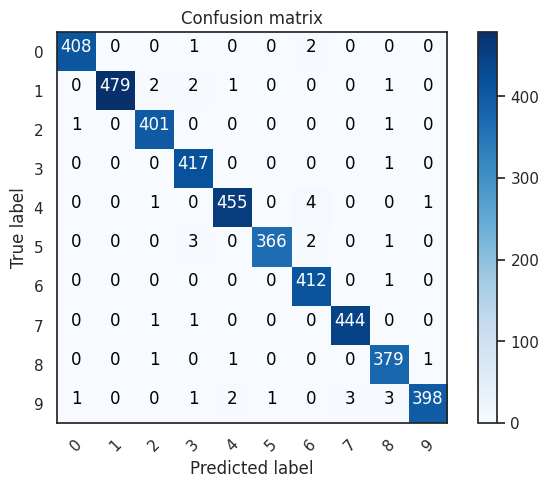

In [66]:
plot_confusion_matrix(confusion_mtx, classes = range(10))

Here we can see that our CNN performs very well on all digits with few errors considering the size of the validation set (4200 images).

However, it seems that our CNN has some little troubles with the 4 digits, they are misclassified as 9. Sometime it is very difficult to catch the difference between 4 and 9 when curves are smooth.

Let's investigate for errors.

I want to see the most important errors . For that purpose i need to get the difference between the probabilities of real value and the predicted ones in the results.

Calculate errors

In [67]:
errors = (Y_pred_classes - Y_true != 0)

In [68]:
Y_pred_classes_errors = Y_pred_classes[errors]

In [69]:
Y_pred_errors = Y_pred[errors]

Get true values

In [70]:
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

**Showing 6 images with their predicted and real labels**

In [71]:
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

Probabilities of the wrong predicted numbers

In [72]:
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

Predicted probabilities of the true values in the error set

In [73]:
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

Difference between the probability of the predicted label and the true label

In [74]:
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

Sorted list of the delta prob errors

In [75]:
sorted_dela_errors = np.argsort(delta_pred_true_errors)

Top 6 errors


In [76]:
most_important_errors = sorted_dela_errors[-6:]

Show the top 6 errors

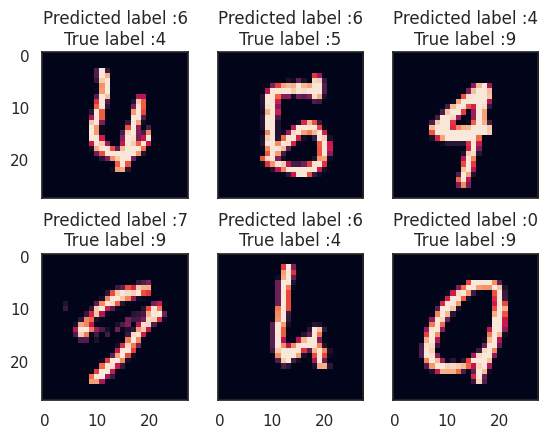

In [77]:
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

The most important errors are also the most intrigous.

For those six case, the model is not ridiculous. Some of these errors can also be made by humans, especially for one the 9 that is very close to a 4. The last 9 is also very misleading, it seems for me that is a 0.

##Predict and Submit Result

**Predict Results**

In [78]:
results = model.predict(test)

875/875 [==============================] - 63s 72ms/step


In [81]:
results

0        2
1        0
2        9
3        0
4        3
        ..
27995    9
27996    7
27997    3
27998    9
27999    2
Name: Label, Length: 28000, dtype: int64

Select the indix with the maximum probability

In [79]:
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

**Submit Results**

In [80]:
submission = pd.concat([pd.Series(range(1,10001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)

##Conclusion

With this we come to the end of this project.  
We were able to sucessfully load the data, perform data preprocessing, create the CNN architecture, augment data and evaluate our model to classify the handwritten digits of the MNIST dataset. We also used RMSProp Optimizer and Annealer to fine tune the learning rate, and achieve the lowest possible error value.